## Метод ближайших соседей для классификации

Импортируем библиотеки

In [1]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

Загружаем данные и трансформируем **Рейтинг** в численный вектор

In [2]:
df = pd.read_excel('./data_3_course.xlsx')
df['Рейтинг'] = df['Рейтинг'].apply(lambda x: float(x.replace(',', '.')))
df.head()

,Timestamp,ID,Рейтинг,Группа (в формате 182),МИ?,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3","Весенний курс по выбору, приоритет 1","Весенний курс по выбору, приоритет 2","Весенний курс по выбору, приоритет 3",Вы заполняете анкету в первый раз?
0,2020-05-15 01:12:50.543,93ff79a51cd602f1dd3028ba2c129503,704.0,181,NaN,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
1,2020-05-15 02:46:48.066,26b01b1c4cd5656bab18d24c548834fb,646.0,181,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL,Дискретная оптимизация,Численные методы,Машинное обучение 2,Нет
2,2020-05-15 03:12:41.480,30f3653fc176d54e89ac3179c455c6dd,624.0,185,NaN,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов,Дискретная оптимизация,Машинное обучение 2,Численные методы,Да
3,2020-05-15 04:43:08.994,1528f0eaa027580820ccf0d92a53ad68,579.0,182,NaN,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления,Дискретная оптимизация,Численные методы,Машинное обучение 2,Да
4,2020-05-15 07:47:17.197,496ea4f0d4abe264b1bb1b80eb3830c5,632.0,183,NaN,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных,Компьютерные сети,Дискретная оптимизация,Численные методы,Да


Способ применения one-hot encoding-a к категориальному признаку:

In [3]:
pd.get_dummies(df['Осенний курс по выбору, приоритет 1'])

,Statistical Learning Theory,Безопасность компьютерных систем,Высокопроизводительные вычисления,Матричные вычисления,Моделирование временных рядов,Принятие решений в условиях риска и неопределённости,Сбор и обработка данных с помощью краудсорсинга,Теория баз данных,Язык SQL
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
218,0,1,0,0,0,0,0,0,0
219,0,0,0,0,0,0,0,1,0
220,0,0,0,0,0,0,0,0,1
221,0,0,0,0,0,0,0,1,0


### Кросс-валидация

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [4]:
# Класс для кросс-валидации
kf = KFold()

In [5]:
# Определяем матрицу признаков
X = df[['Рейтинг', 'Осенний курс по выбору, приоритет 1', 'Осенний курс по выбору, приоритет 2', 'Осенний курс по выбору, приоритет 3']]
X

,Рейтинг,"Осенний курс по выбору, приоритет 1","Осенний курс по выбору, приоритет 2","Осенний курс по выбору, приоритет 3"
0,704.0,Язык SQL,Высокопроизводительные вычисления,Матричные вычисления
1,646.0,Высокопроизводительные вычисления,Безопасность компьютерных систем,Язык SQL
2,624.0,Безопасность компьютерных систем,Матричные вычисления,Моделирование временных рядов
3,579.0,Statistical Learning Theory,Высокопроизводительные вычисления,Матричные вычисления
4,632.0,Высокопроизводительные вычисления,Безопасность компьютерных систем,Теория баз данных
...,...,...,...,...
218,517.0,Безопасность компьютерных систем,Теория баз данных,Язык SQL
219,634.0,Теория баз данных,Безопасность компьютерных систем,Моделирование временных рядов
220,584.0,Язык SQL,Теория баз данных,Безопасность компьютерных систем
221,646.0,Теория баз данных,Высокопроизводительные вычисления,Безопасность компьютерных систем


In [6]:
# Определяем вектор признаков. Делаем его строковым (каким он на самом деле и является).
y = df['Группа (в формате 182)'].astype(str)
y

0      181
1      181
2      185
3      182
4      183
      ... 
218    185
219    184
220    188
221    186
222    188
Name: Группа (в формате 182), Length: 223, dtype: object

In [7]:
# Категоризуем вектор: заменяем строковые значения на числа от 0 до (*число уникальных значений* - 1)
labels, keys = y.factorize()

In [8]:
# Метрика accuracy
def accuracy(y, y_pred):
    return sum(y == y_pred) / len(y)

In [9]:
# При помощи кросс-валидации оцениваем модель kNN с весами с гиперпараметром `n_neighbors=5`
for (train_idx, test_idx) in kf.split(y):
    X_train = X.iloc[train_idx]
    y_train = labels[train_idx]
    
    X_test = X.iloc[test_idx]
    y_test = labels[test_idx]
    
    ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), X.columns[1:])])
    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)
    
    knn = KNeighborsClassifier(weights='distance')
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    acc_test = accuracy(y_test, y_pred)
    print(f'Accuracy on test data: {acc_test:.4f}')
    
    y_pred = knn.predict(X_train)
    acc_train = accuracy(y_train, y_pred)
    print(f'Accuracy on train data: {acc_train:.4f}\n')

Accuracy on test data: 0.2222
Accuracy on train data: 0.7753

Accuracy on test data: 0.2222
Accuracy on train data: 0.7809

Accuracy on test data: 0.2444
Accuracy on train data: 0.7753

Accuracy on test data: 0.2955
Accuracy on train data: 0.8101

Accuracy on test data: 0.2273
Accuracy on train data: 0.7821



### А теперь посмотрим на наши данные! Разложим их в 2-мерное пространство, сохраняя как можно больше дисперсии.

In [10]:
pca = PCA()

In [11]:
pca_train = pca.fit_transform(X_train.toarray())
pca_test = pca.transform(X_test.toarray())

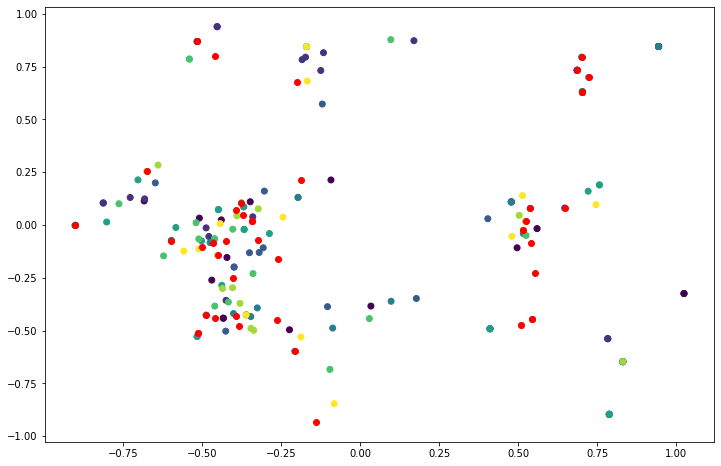

In [12]:
plt.figure(figsize=(12, 8))
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train)
plt.scatter(pca_test[:, 0], pca_test[:, 1], c='Red')